# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import mean, col, desc, count, isnull, isnan, when, rank, sum
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# import os
# cwd = os.getcwd()
# bank_file = "file://" + cwd + "/ML_hw_dataset.csv"
bank_file = "ML_hw_dataset.csv"

bank = spark.read.csv(bank_file, header=True, inferSchema=True)
# bank = spark.read.format("csv").option("header", "True").option("inferSchema", "True").option("sep", ",").load(bank_file)


# Description

## Schema

In [2]:
display(bank.dtypes)
bank.printSchema()

numeric_columns = [column for column, type in bank.dtypes if type == 'int' or type == 'double']      # using dtypes
string_columns = [column for column in bank.columns if bank.schema[column].dataType == StringType()] # using schema


[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('emp_var_rate', 'double'),
 ('cons_price_idx', 'double'),
 ('cons_conf_idx', 'double'),
 ('euribor3m', 'double'),
 ('nr_employed', 'double'),
 ('y', 'int')]

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



## Shape

In [3]:
rows_num = bank.count()
cols_num = len(bank.columns)
print("Number of rows: ", rows_num)
print("Number of columns: ", cols_num)


Number of rows:  41188
Number of columns:  21


## Head

In [4]:
bank.show()


+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no| cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician| married|          unknown|     no|     no|  no| cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|      

## Numerical description

In [5]:
# bank.describe().show()
bank.select(numeric_columns).describe().show()


+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|          duration|          campaign|             pdays|           previous|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|             41188|             41188|             41188|              41188|              41188|             41188|             41188|             41188|            41188|              41188|
|   mean| 40.02406040594348| 258.2850101971448| 2.567592502670681| 962.4754540157328|0.17296299893172767|0.081885500

## Distinct values

In [6]:
# bank.distinct().show()
for column in string_columns:
    bank.select(column).distinct().show()


+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

+--------+
| marital|
+--------+
| unknown|
|divorced|
| married|
|  single|
+--------+

+-------------------+
|          education|
+-------------------+
|        high.school|
|            unknown|
|           basic.6y|
|professional.course|
|  university.degree|
|         illiterate|
|           basic.4y|
|           basic.9y|
+-------------------+

+-------+
|default|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|housing|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|   loan|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+---------+
|  contact|
+---------+
| cellular|
|telephone|
+---------+

+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  sep|
|  mar|
|  oct|
|  jul|
|  nov|
|  apr|
|  dec|

## 5 nums, mean, mode

In [7]:
for column in numeric_columns:
    mean_value = bank.select(mean(column)).collect()[0][0]
    mode_value = bank.groupBy(column).count().sort(desc("count")).select(col(column)).collect()[0][0]
    
    quantiles = bank.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles[0], quantiles[1], quantiles[2]
    iqr = q3 - q1

    minimum = bank.selectExpr(f"min({column})").collect()[0][0]
    maximum = bank.selectExpr(f"max({column})").collect()[0][0]
    
    print(f"{column}:")
    print(f"mean: {mean_value}")
    print(f"mode: {mode_value}")
    print(f"Minimum: {minimum}")
    print(f"Q1: {q1}")
    print(f"Q2 (Median): {median}")
    print(f"Q3: {q3}")
    print(f"Maximum: {maximum}")
    print(f"IQR: {iqr}")
    print("")


age:
mean: 40.02406040594348
mode: 31
Minimum: 17
Q1: 32.0
Q2 (Median): 38.0
Q3: 47.0
Maximum: 98
IQR: 15.0

duration:
mean: 258.2850101971448
mode: 85
Minimum: 0
Q1: 101.0
Q2 (Median): 179.0
Q3: 315.0
Maximum: 4918
IQR: 214.0

campaign:
mean: 2.567592502670681
mode: 1
Minimum: 1
Q1: 1.0
Q2 (Median): 2.0
Q3: 3.0
Maximum: 56
IQR: 2.0

pdays:
mean: 962.4754540157328
mode: 999
Minimum: 0
Q1: 999.0
Q2 (Median): 999.0
Q3: 999.0
Maximum: 999
IQR: 0.0

previous:
mean: 0.17296299893172767
mode: 0
Minimum: 0
Q1: 0.0
Q2 (Median): 0.0
Q3: 0.0
Maximum: 7
IQR: 0.0

emp_var_rate:
mean: 0.08188550063125773
mode: 1.4
Minimum: -3.4
Q1: -1.8
Q2 (Median): 1.1
Q3: 1.4
Maximum: 1.4
IQR: 3.2

cons_price_idx:
mean: 93.57566436827047
mode: 93.994
Minimum: 92.201
Q1: 93.075
Q2 (Median): 93.444
Q3: 93.994
Maximum: 94.767
IQR: 0.9189999999999969

cons_conf_idx:
mean: -40.50260027192026
mode: -36.4
Minimum: -50.8
Q1: -42.7
Q2 (Median): -41.8
Q3: -36.4
Maximum: -26.9
IQR: 6.300000000000004

euribor3m:
mean: 3.6212

## Count per category

In [8]:
for column in string_columns:
    result = bank.groupBy(column).count().orderBy("count", ascending=False)
    display(result.toPandas())


,job,count
0,admin.,10422
1,blue-collar,9254
2,technician,6743
3,services,3969
4,management,2924
5,retired,1720
6,entrepreneur,1456
7,self-employed,1421
8,housemaid,1060
9,unemployed,1014


,marital,count
0,married,24928
1,single,11568
2,divorced,4612
3,unknown,80


,education,count
0,university.degree,12168
1,high.school,9515
2,basic.9y,6045
3,professional.course,5243
4,basic.4y,4176
5,basic.6y,2292
6,unknown,1731
7,illiterate,18


,default,count
0,no,32588
1,unknown,8597
2,yes,3


,housing,count
0,yes,21576
1,no,18622
2,unknown,990


,loan,count
0,no,33950
1,yes,6248
2,unknown,990


,contact,count
0,cellular,26144
1,telephone,15044


,month,count
0,may,13769
1,jul,7174
2,aug,6178
3,jun,5318
4,nov,4101
5,apr,2632
6,oct,718
7,sep,570
8,mar,546
9,dec,182


,day_of_week,count
0,thu,8623
1,mon,8514
2,wed,8134
3,tue,8090
4,fri,7827


,poutcome,count
0,nonexistent,35563
1,failure,4252
2,success,1373


## Missing values

In [9]:
null_counts = bank.select([count(when(isnull(c), c)).alias(c) for c in bank.columns]).toPandas().T
null_counts.columns = ['Null Count']
display(null_counts)

unk_counts = bank.select([count(when(bank[c].like('unknown'), c)).alias(c) for c in bank.columns]).toPandas().T
unk_counts.columns = ['Unknown Count']
display(unk_counts)

nine_counts = bank.select([count(when(bank[c] == 999, c)).alias(c) for c in bank.columns]).toPandas().T
nine_counts.columns = ['999 Count']
display(nine_counts)

nan_counts = bank.select([count(when(isnan(c), c)).alias(c) for c in bank.columns]).toPandas().T
nan_counts.columns = ['NaN Count']
display(nan_counts)


,Null Count
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


,Unknown Count
age,0
job,330
marital,80
education,1731
default,8597
housing,990
loan,990
contact,0
month,0
day_of_week,0


,999 Count
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


,NaN Count
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


# Plots

## Correlation matrix

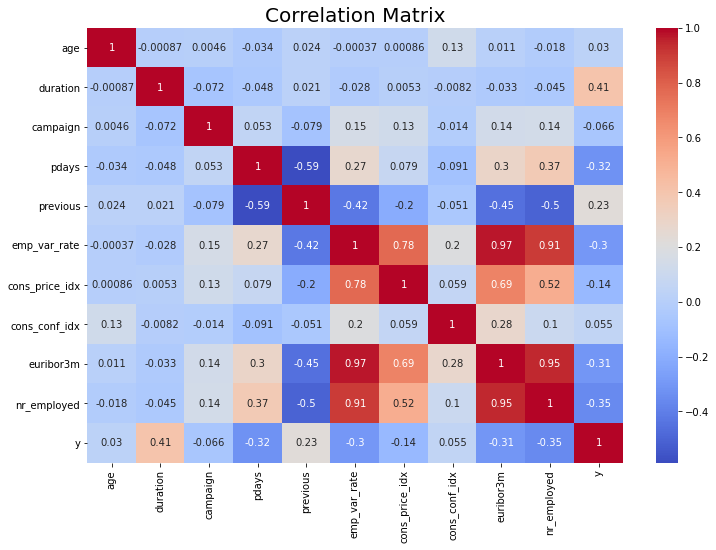

In [10]:
def corr_mat(bank, numeric_columns, width, height):
    # Using pandas's corr():

    # corr_matrix = bank.select([c for c in bank.columns]).toPandas().corr(method="pearson")

    # Using pyspark's Statistics.corr():

    from pyspark.mllib.stat import Statistics


    numeric_df = bank.select(numeric_columns)
    feature_vector = numeric_df.rdd.map(lambda row: row[0:])
    corr_matrix = Statistics.corr(feature_vector, method="pearson")

    corr_matrix_df = pd.DataFrame(corr_matrix)
    corr_matrix_df.index, corr_matrix_df.columns = numeric_columns, numeric_columns
    # display(corr_matrix_df)

    # Plotting

    import seaborn as sns


    plt.figure(figsize=(width, height))
    sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix', fontsize=20)
    plt.show()

corr_mat(bank, numeric_columns, 12, 8)


## Convert string to numerical

In [11]:
from pyspark.ml.feature import StringIndexer

string_columns_index = [column + '_index' for column in string_columns]
stringIndexer = StringIndexer().setInputCols(string_columns).setOutputCols(string_columns_index)
string_indexer_model = stringIndexer.fit(bank)
df = string_indexer_model.transform(bank)

for column in string_columns:
    df = df.drop(column)

df.show()


+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| 44|     210|       1|  999|       0|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|      1.0|          0.0|            4.0|          1.0|          0.0|       0.0|          0.0|        2.0|              0.0|           0.0|
| 53|     138|      

## Correlation matrix with string indexes

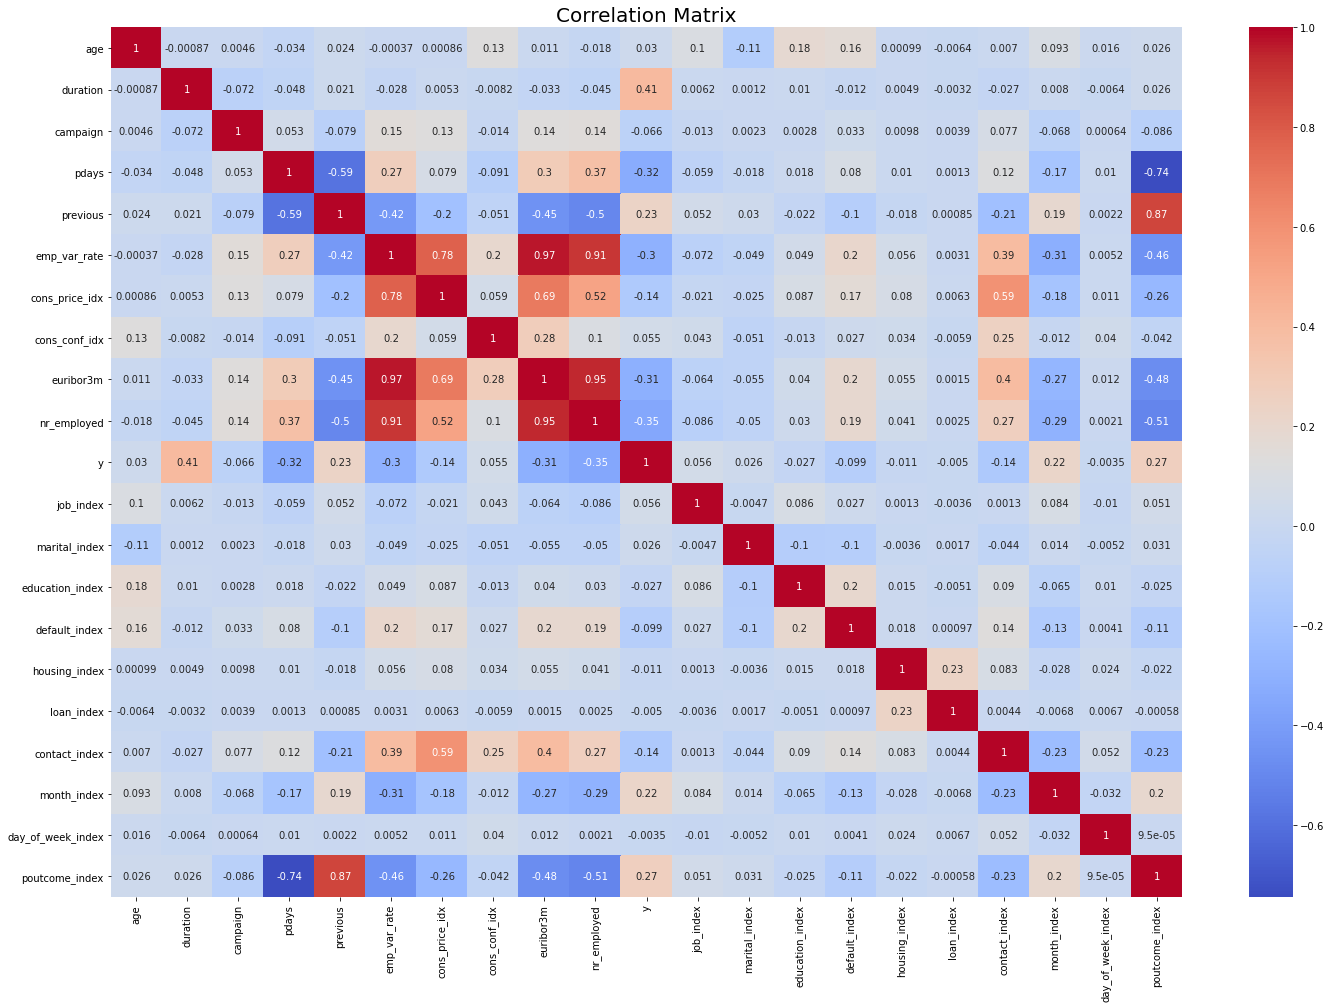

In [12]:
new_numeric_columns = numeric_columns + [column for column in df.columns if column.endswith('_index')]
corr_mat(df, new_numeric_columns, 24, 16)


## Contingency table

In [13]:
for column in string_columns:
    contingency_table = bank.crosstab(column, 'y')
    # contingency_table.show()
    display(contingency_table.toPandas())
    

,job_y,0,1
0,housemaid,954,106
1,services,3646,323
2,self-employed,1272,149
3,student,600,275
4,retired,1286,434
5,unknown,293,37
6,admin.,9070,1352
7,blue-collar,8616,638
8,technician,6013,730
9,entrepreneur,1332,124


,marital_y,0,1
0,unknown,68,12
1,divorced,4136,476
2,single,9948,1620
3,married,22396,2532


,education_y,0,1
0,basic.9y,5572,473
1,basic.4y,3748,428
2,high.school,8484,1031
3,unknown,1480,251
4,basic.6y,2104,188
5,professional.course,4648,595
6,university.degree,10498,1670
7,illiterate,14,4


,default_y,0,1
0,unknown,8154,443
1,no,28391,4197
2,yes,3,0


,housing_y,0,1
0,unknown,883,107
1,no,16596,2026
2,yes,19069,2507


,loan_y,0,1
0,unknown,883,107
1,no,30100,3850
2,yes,5565,683


,contact_y,0,1
0,telephone,14257,787
1,cellular,22291,3853


,month_y,0,1
0,jul,6525,649
1,nov,3685,416
2,apr,2093,539
3,oct,403,315
4,sep,314,256
5,jun,4759,559
6,mar,270,276
7,aug,5523,655
8,dec,93,89
9,may,12883,886


,day_of_week_y,0,1
0,mon,7667,847
1,thu,7578,1045
2,tue,7137,953
3,fri,6981,846
4,wed,7185,949


,poutcome_y,0,1
0,failure,3647,605
1,nonexistent,32422,3141
2,success,479,894


## KDE (Distribution), Histogram, Boxplot

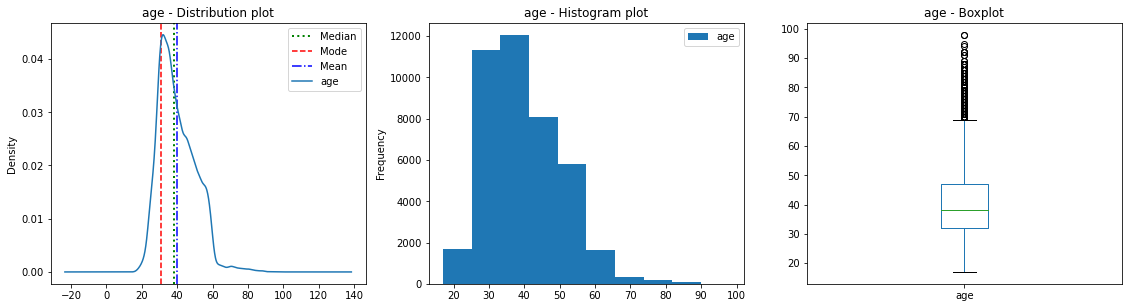

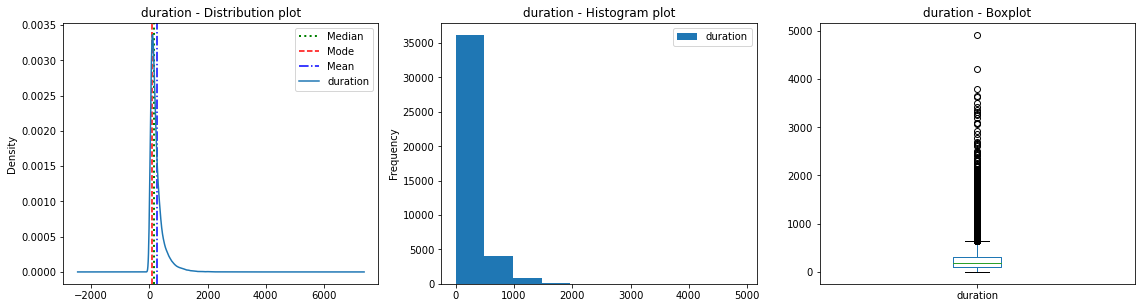

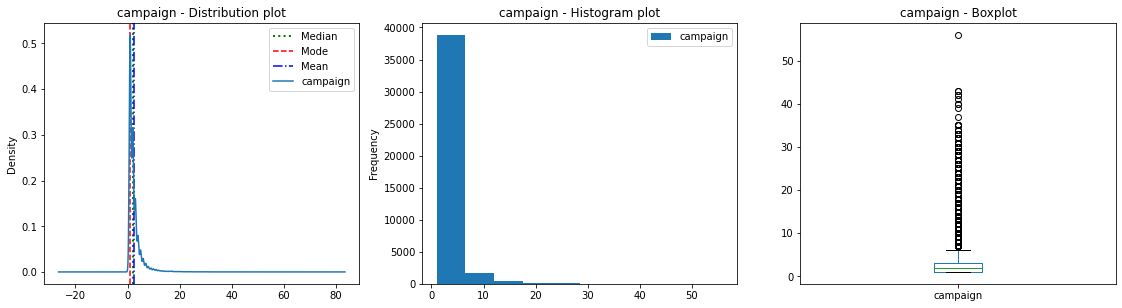

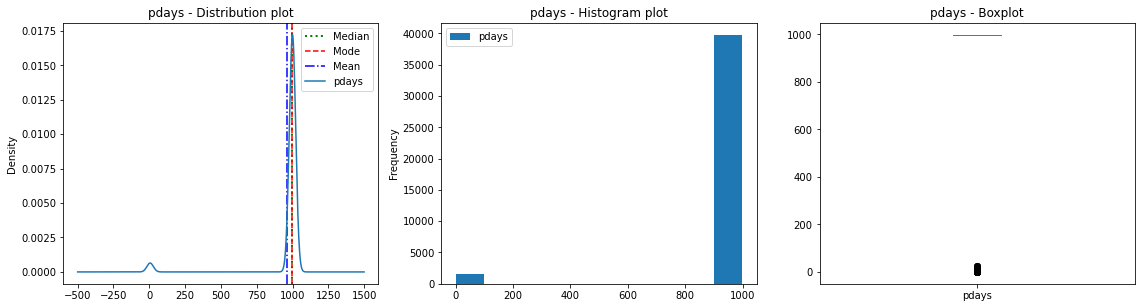

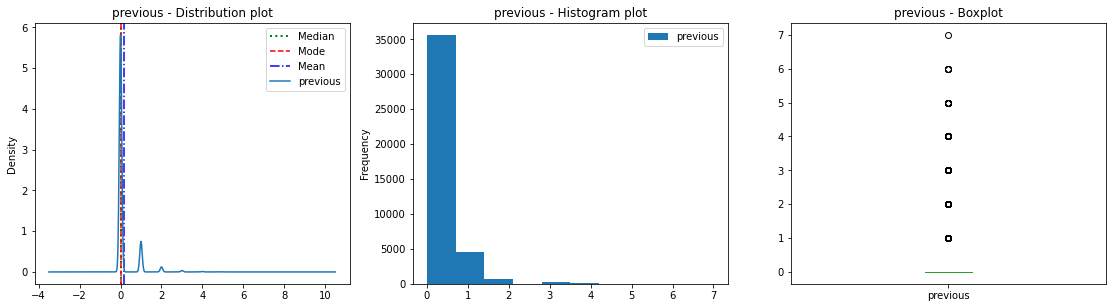

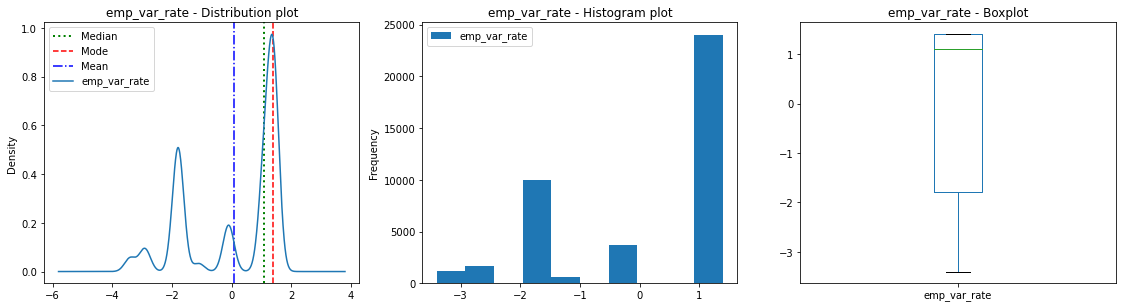

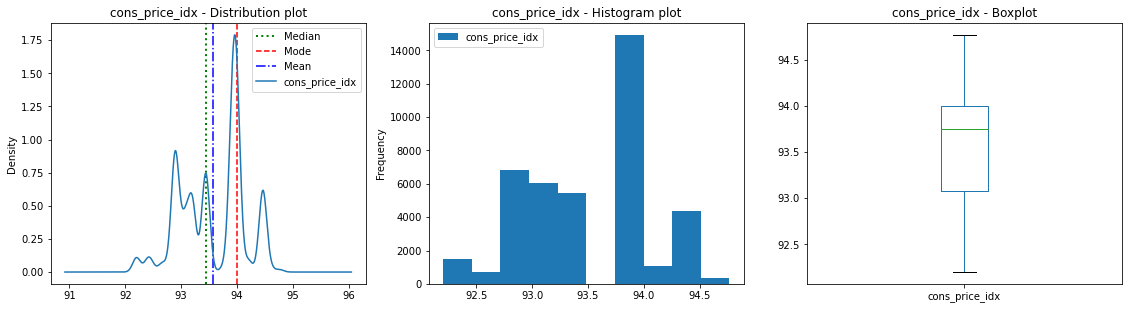

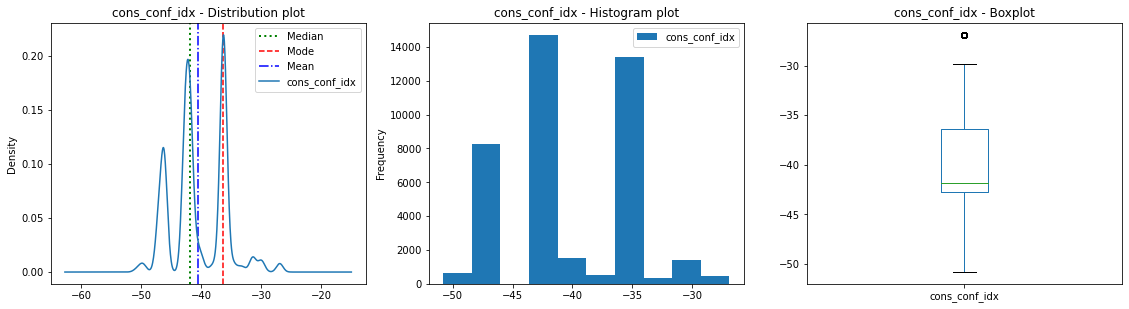

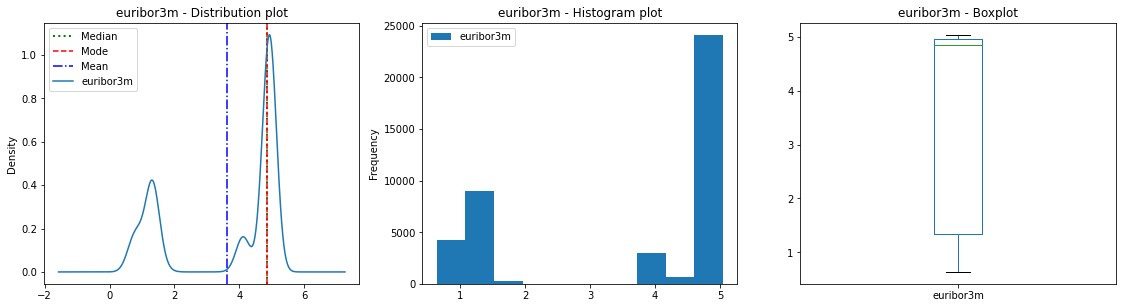

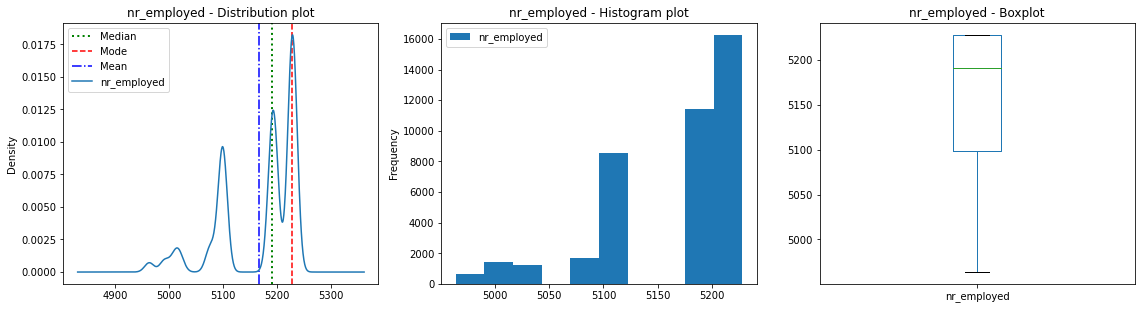

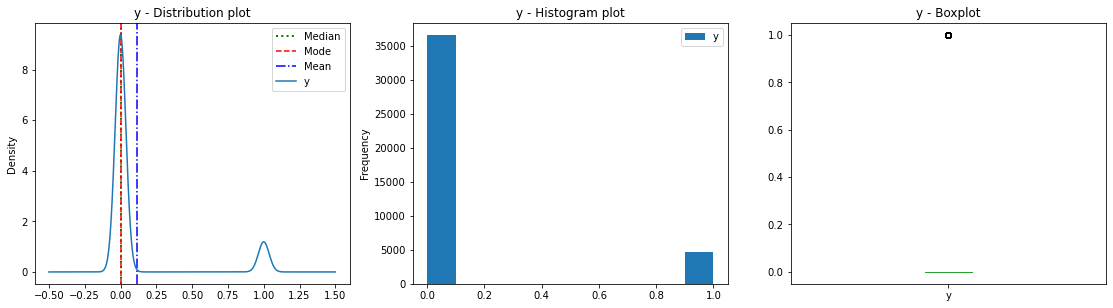

In [14]:
def three_plots(bank):
    for i, column in enumerate(numeric_columns):
        fig, axs = plt.subplots(1, 3, figsize=(6.4*3, 4.8))
        pdf = bank.select(column).toPandas()

        mean_value = bank.select(mean(column)).collect()[0][0]
        mode_value = bank.groupBy(column).count().sort(desc("count")).select(col(column)).collect()[0][0]
        median = bank.approxQuantile(column, [0.5], 0.01)[0]

        axs[0].set_title(column + " - Distribution plot")
        axs[0].axvline(median, color='green', label='Median', linestyle=':', linewidth=2)
        axs[0].axvline(mode_value, color='red', label='Mode', linestyle='--')
        axs[0].axvline(mean_value, color='blue', label='Mean', linestyle='-.')
        axs[0].legend()
        pdf.plot.kde(ax=axs[0])

        axs[1].set_title(column + " - Histogram plot")
        pdf.plot.hist(ax=axs[1])
        
        axs[2].set_title(column + " - Boxplot")
        pdf.plot.box(ax=axs[2])

        plt.show()

three_plots(bank)


## Scatterplots

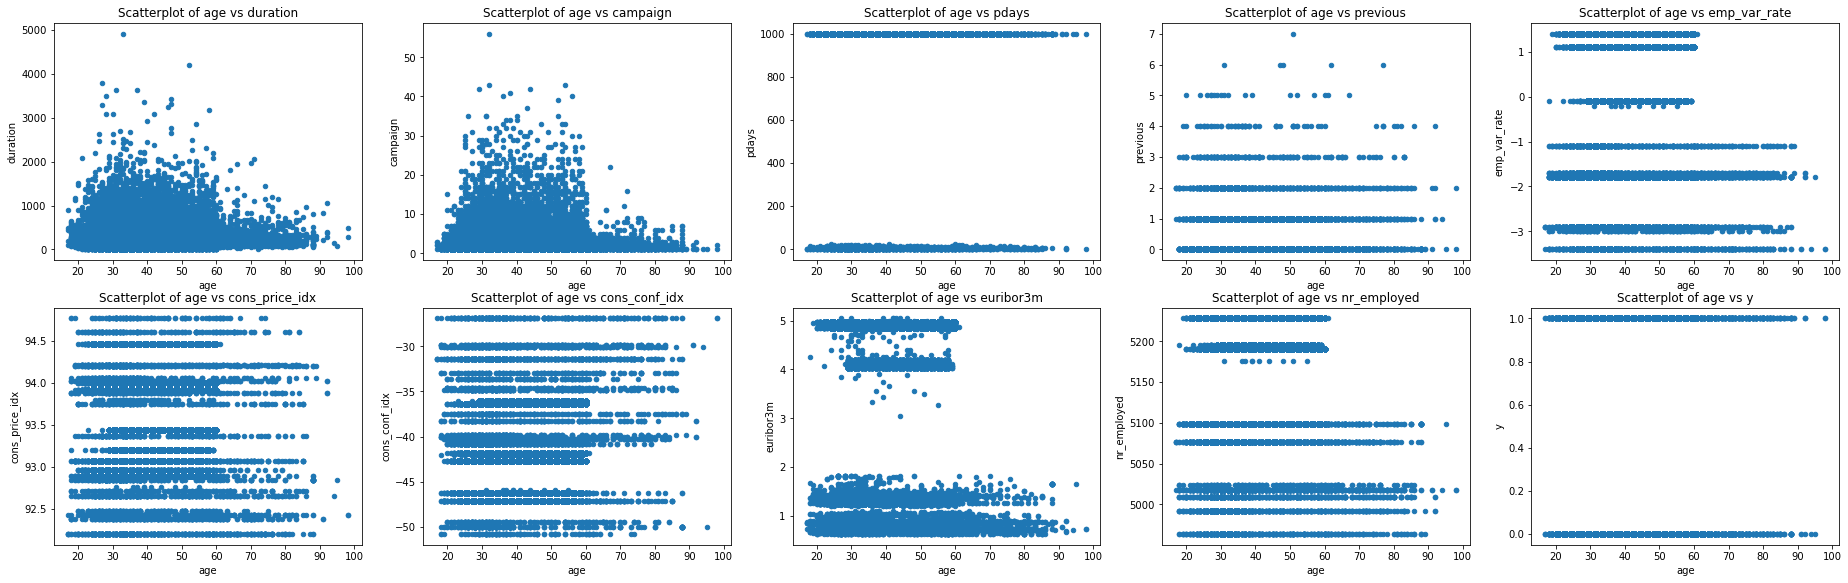

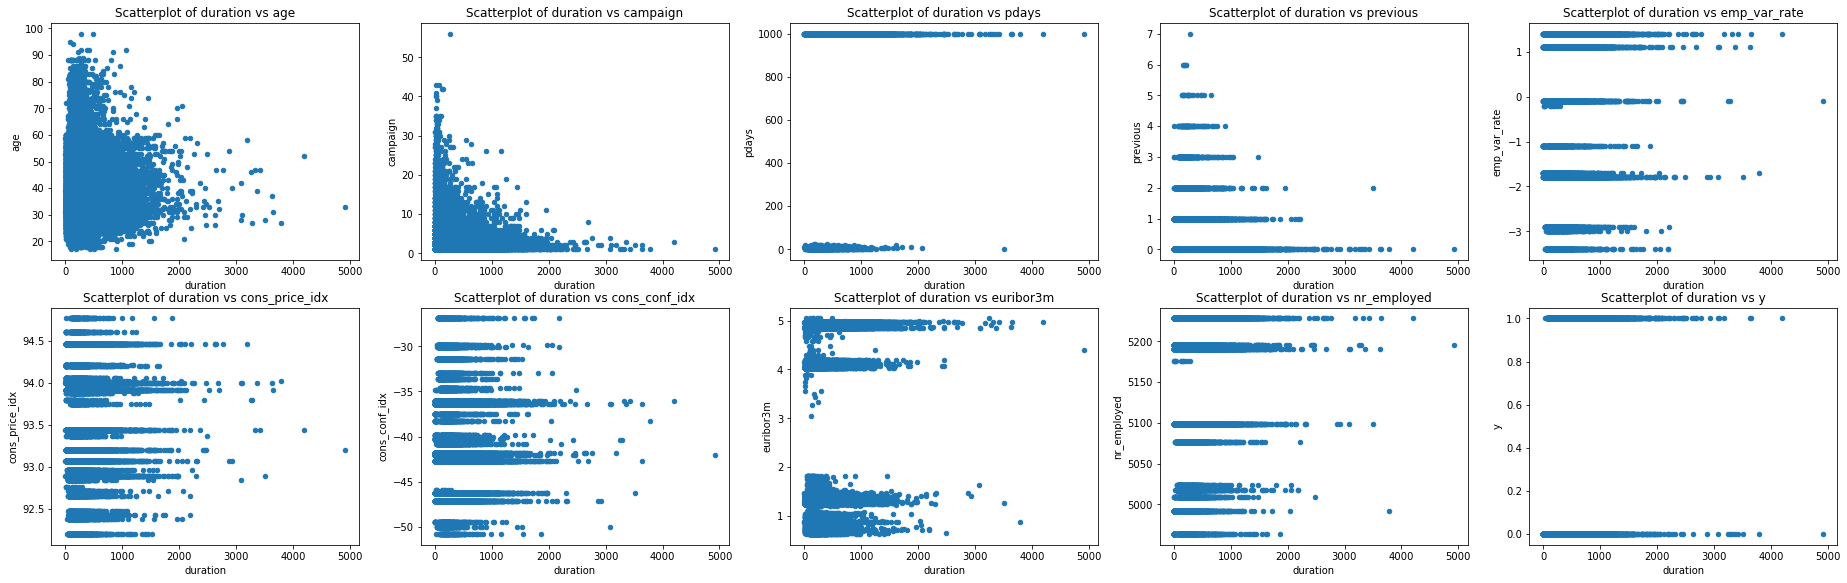

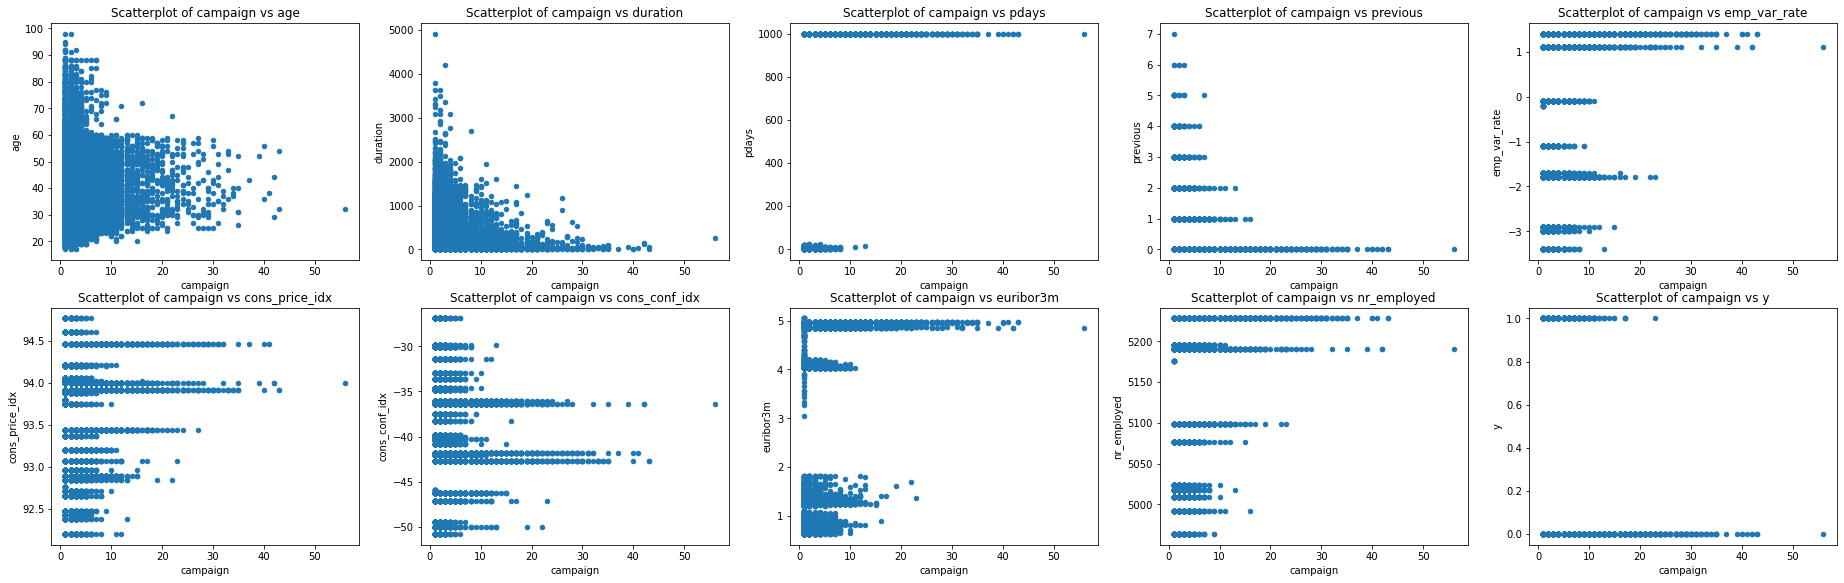

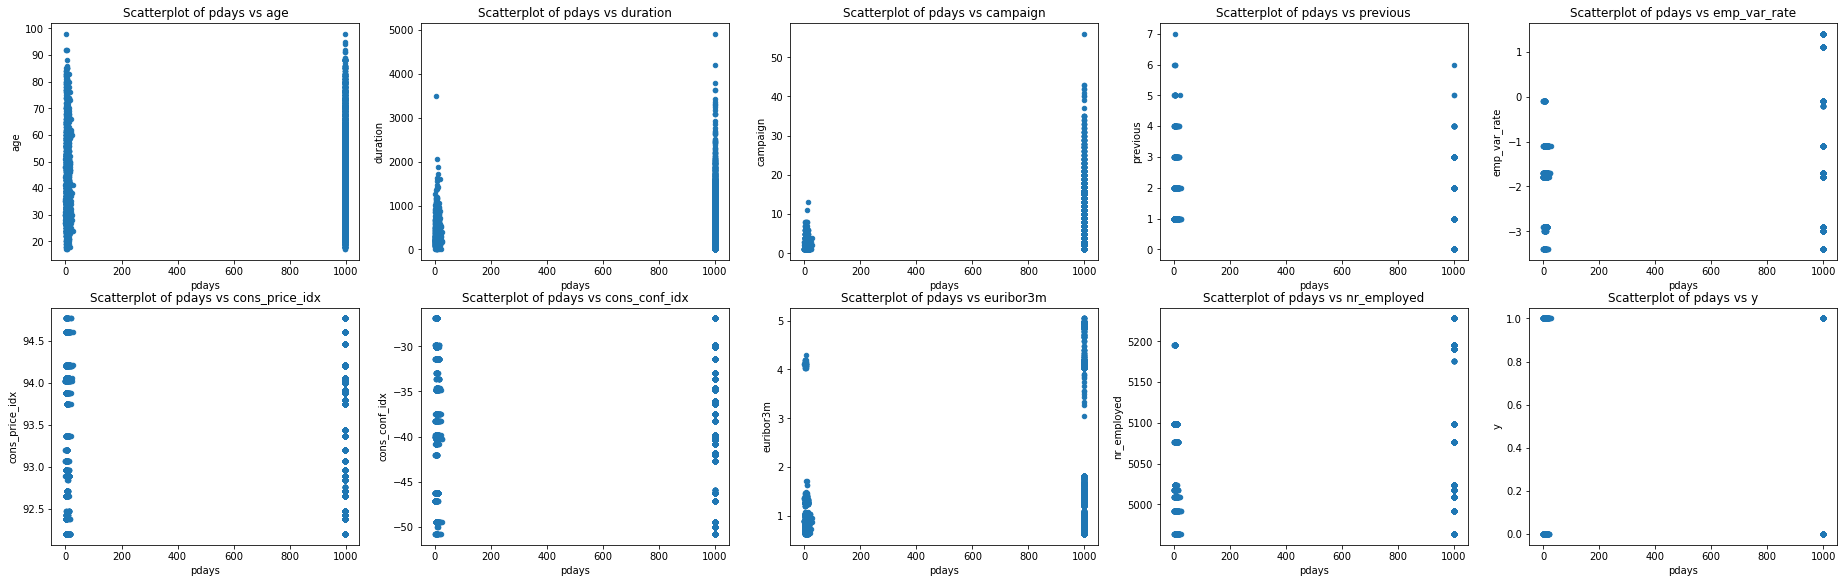

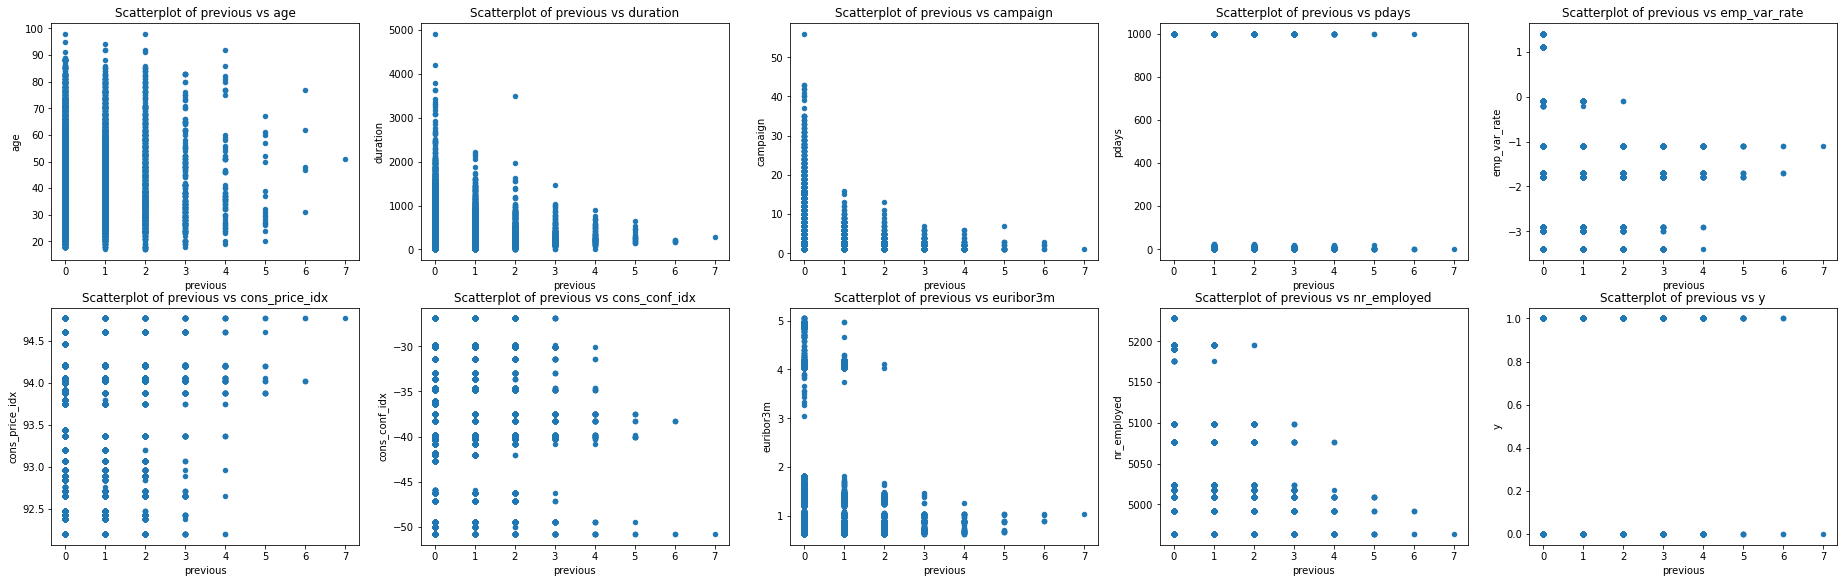

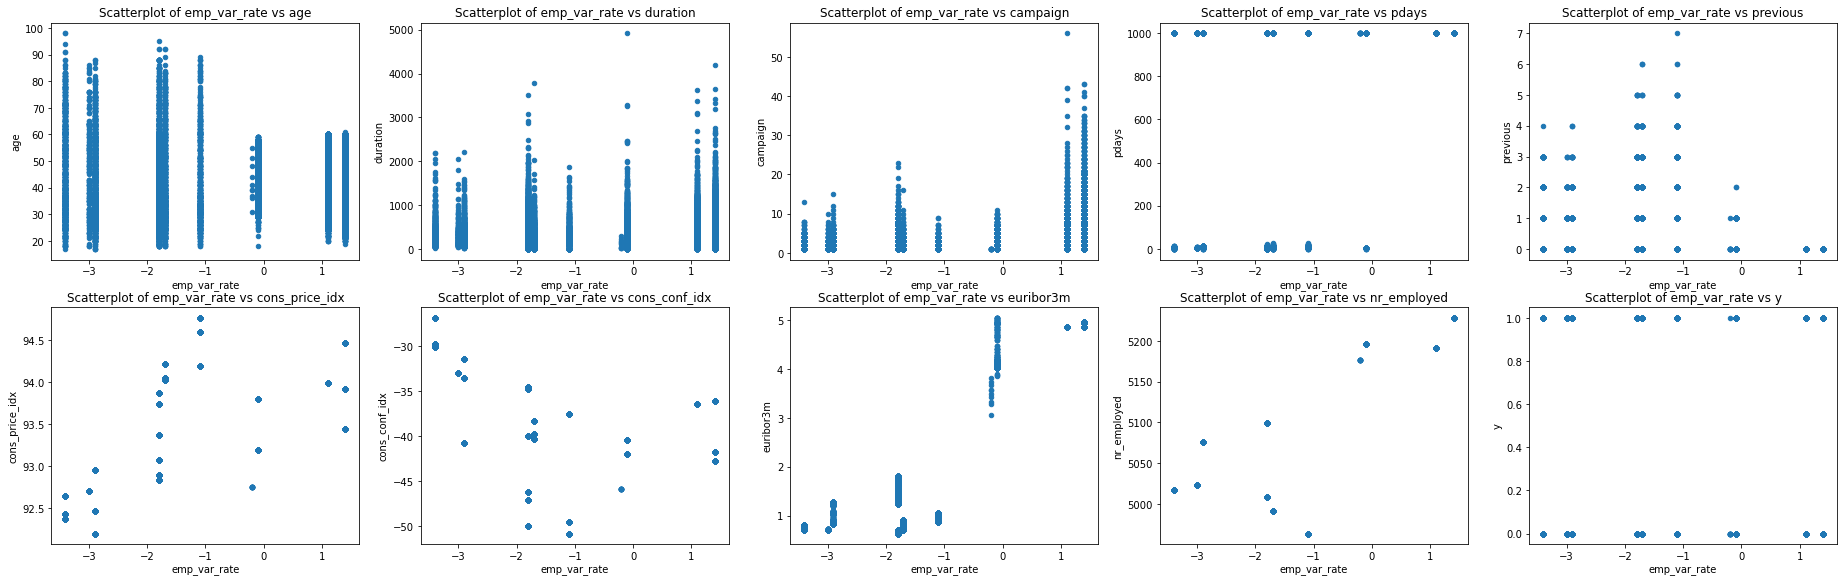

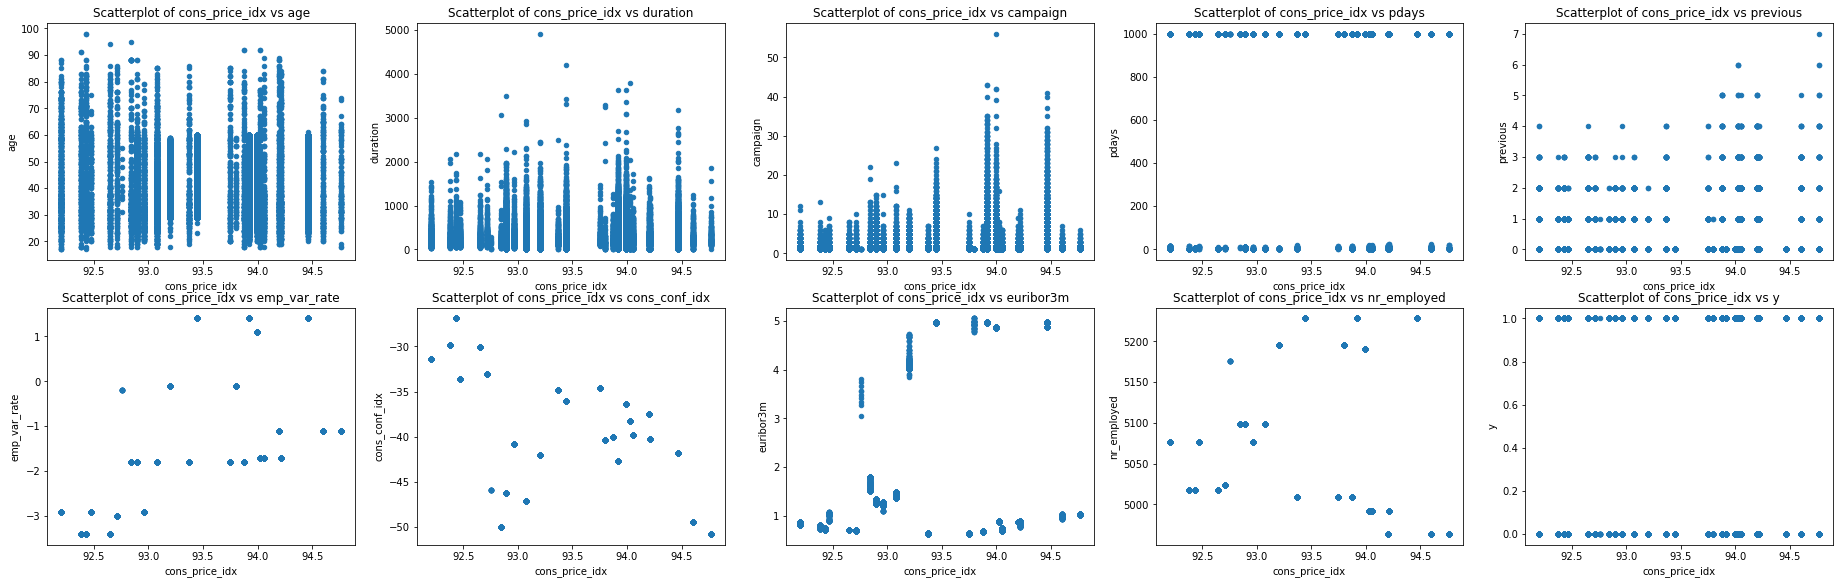

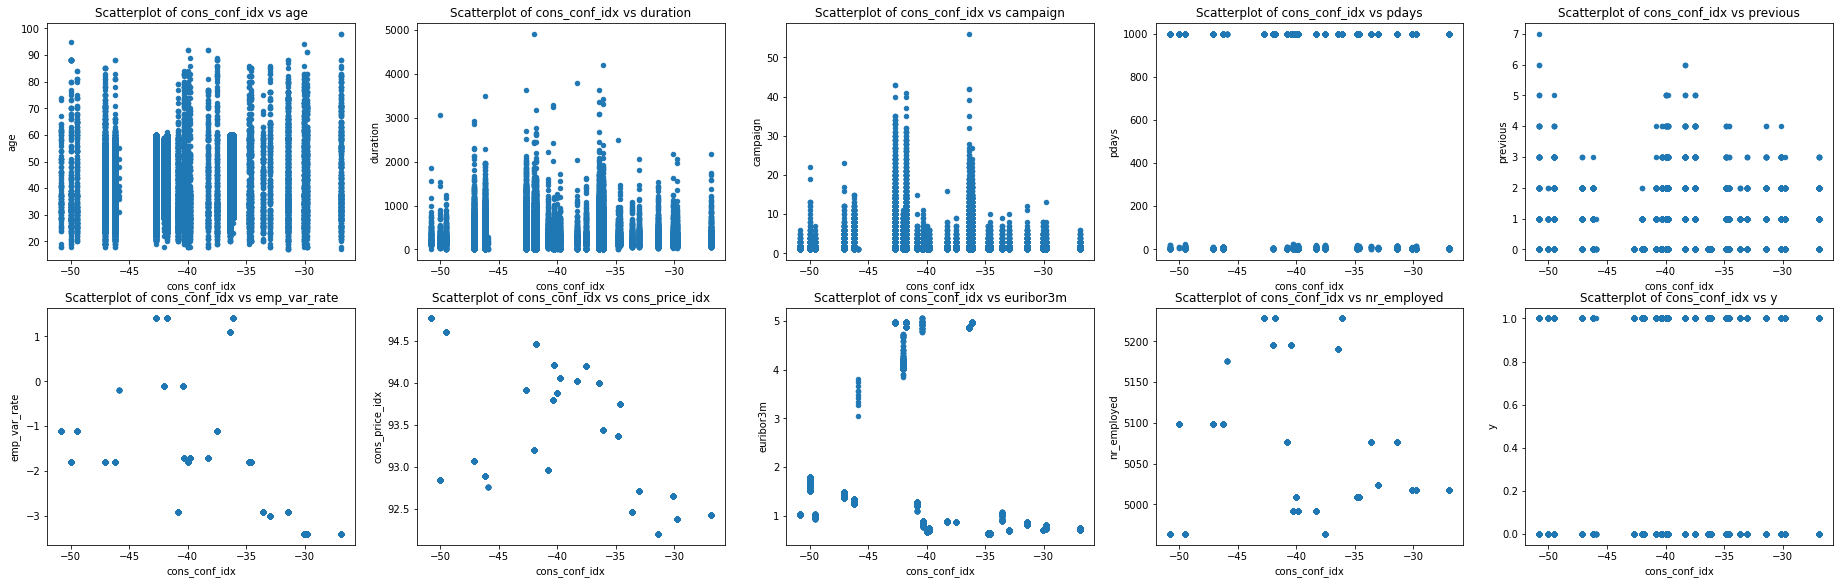

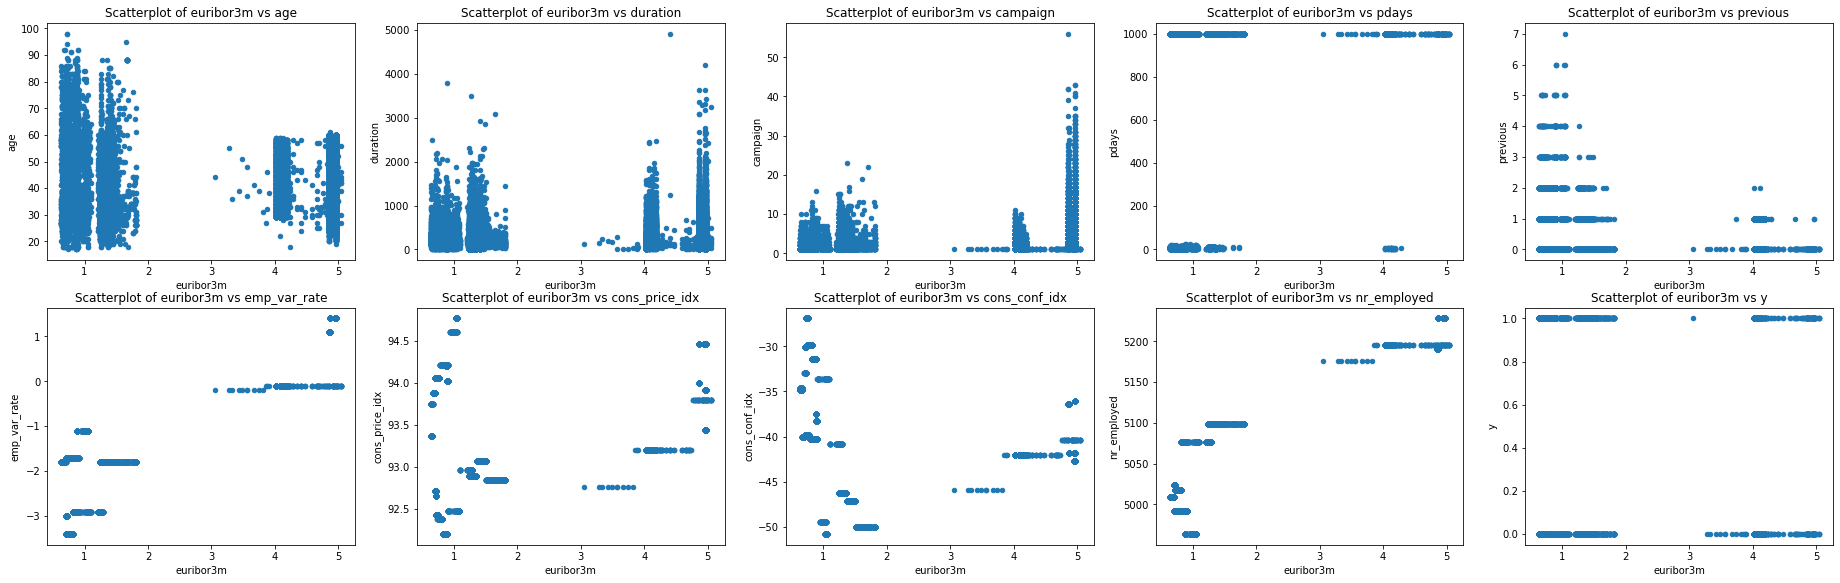

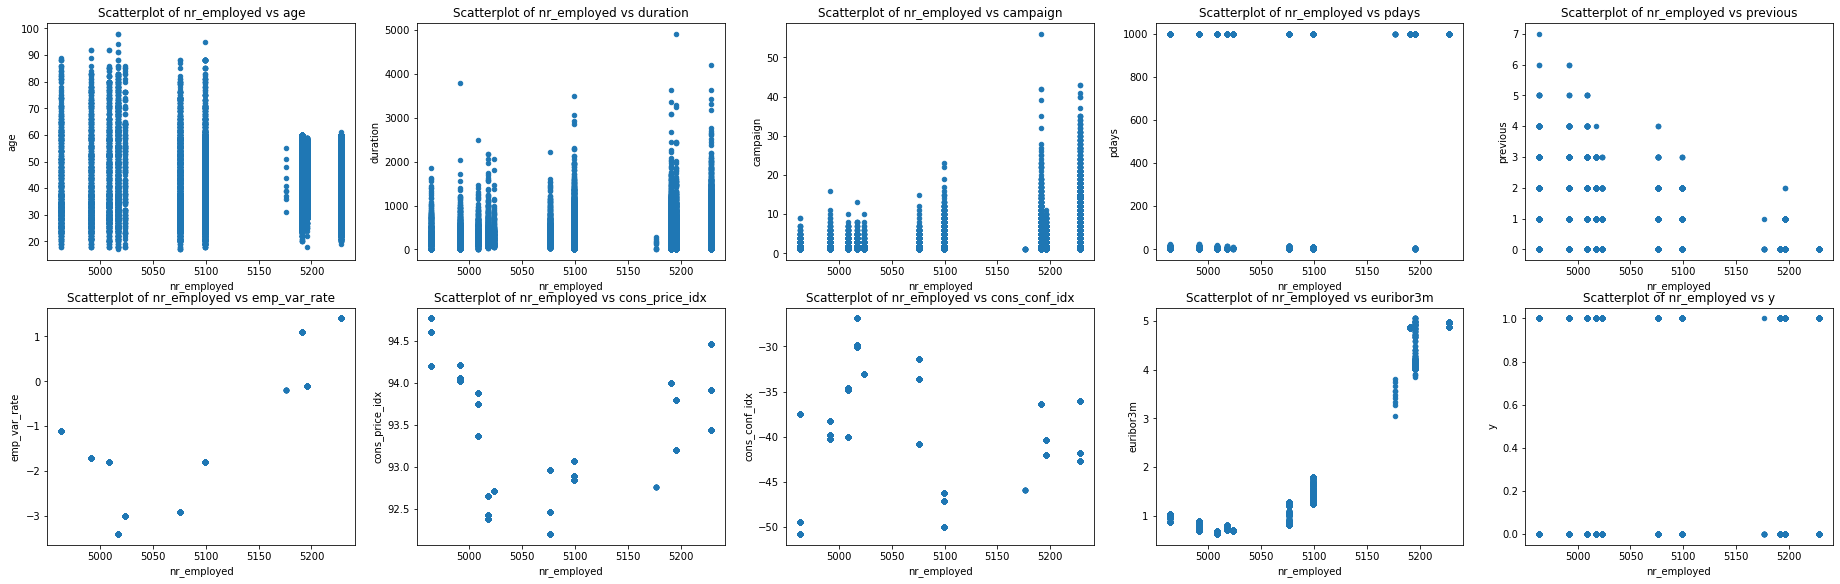

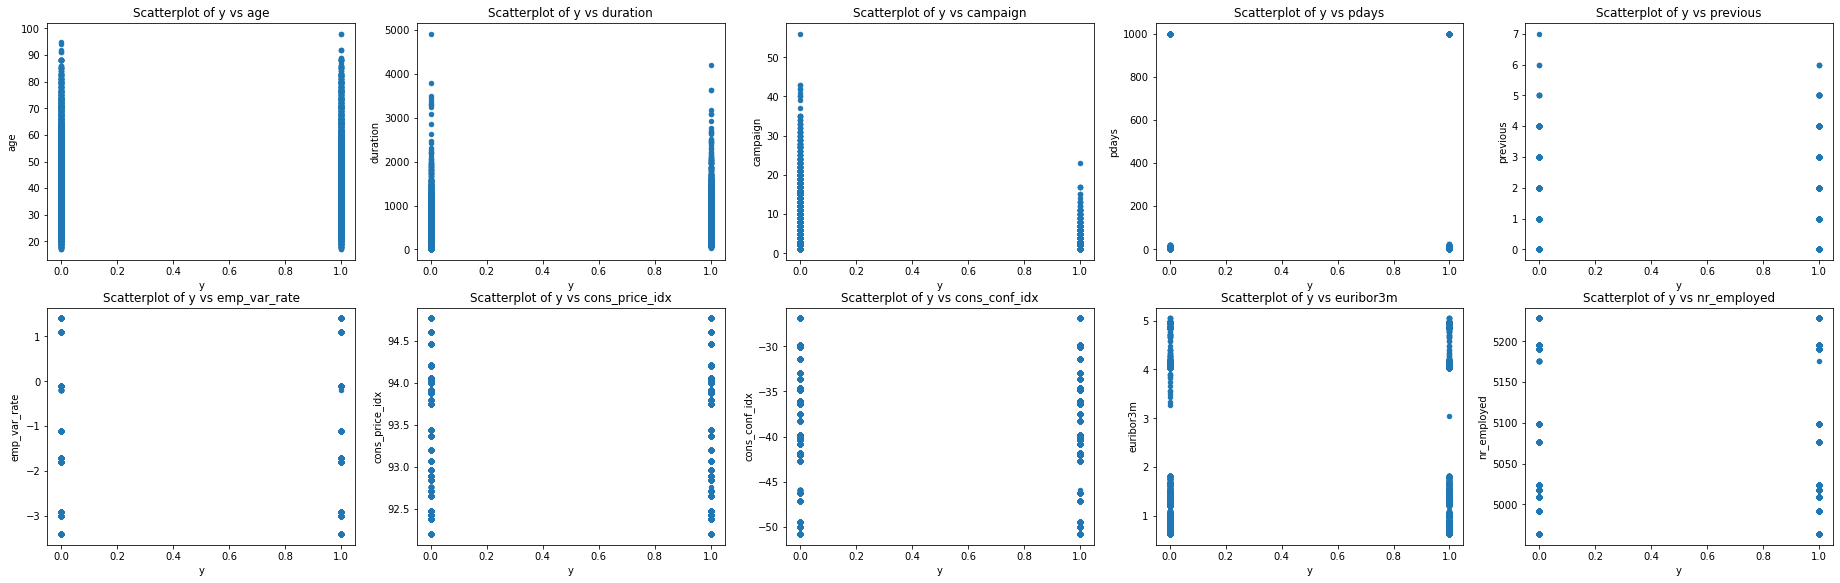

In [15]:
# Remove duplicates

# combined_columns = dict()
# for column in numeric_columns:
#     for second_column in numeric_columns:
#         if column != second_column:
#             if (column not in combined_columns) or (column in combined_columns and second_column not in combined_columns[column]):
#                 if second_column not in combined_columns or (second_column in combined_columns and column not in combined_columns[second_column]):
#                     if column not in combined_columns:
#                         combined_columns[column] = set()
#                     combined_columns[column].add(second_column)

# for column, second_columns in combined_columns.items():
#     i=0
#     fig, axs = plt.subplots(1, len(second_columns), figsize=(6.4*len(second_columns), 4.8))
#     for second_column in second_columns:
#         pdf = bank.toPandas()
#         if len(second_columns) > 1:
#             axs[i].set_title(f'Scatterplot of {column} vs {second_column}')
#             pdf.plot.scatter(x=column, y=second_column, ax=axs[i])
#         else:
#             axs.set_title(f'Scatterplot of {column} vs {second_column}')
#             pdf.plot.scatter(x=column, y=second_column, ax=axs)
#         i=i+1
#     plt.show()


# Don't remove duplicates (better for finding)

for column in numeric_columns:
    i, j = 0, 0
    fig, axs = plt.subplots(2, 5, figsize=(6.4*5, 4.8*2))
    for second_column in numeric_columns:
        if column != second_column:
            if j == 5:
                j = 0
                i = i + 1
            pdf = bank.toPandas()
            axs[i, j].set_title(f'Scatterplot of {column} vs {second_column}')
            pdf.plot.scatter(x=column, y=second_column, ax=axs[i, j])
            j = j + 1
    plt.show()
